# Blue Sky Run Engine

Contents:

* The Run Engine processes messages
* There is two-way communication between the message generator and the Run Engine
* Control timing with 'sleep' and 'wait'
* Runs can be paused and cleanly resumed or aborted
* Any functions can subscribe to the live data stream (e.g., live plotting)
* Fly Scan Prototype

In [97]:
%run bs.py

motor = Mover('motor', ['pos'])
det = SynGauss('sg', motor, 'pos', center=0, Imax=1, sigma=1)

## The Run Engine processes messages

A message has four parts: a command string, an object, a tuple of positional arguments, and a dictionary of keyword arguments.

In [98]:
Msg('set', motor, {'pos': 5})

set: (mover: motor), ({'pos': 5},), {}

In [99]:
Msg('trigger', motor)

trigger: (mover: motor), (), {}

In [100]:
Msg('read', motor)

read: (mover: motor), (), {}

In [101]:
RE = RunEngine()

In [6]:
def simple_scan(motor):
    "Set, trigger, read"
    yield Msg('set', motor, {'pos': 5})
    yield Msg('trigger', motor)
    yield Msg('read', motor)
    
RE.run(simple_scan(motor))

*** Emitted RunStart:
{'time': 1433073995.968266, 'uid': '263ab7c5-30b0-4d13-b85e-999b25eae4fa', 'owner': 'tester', 'scan_id': 123, 'beamline_id': 'test'}
MSG_CACHE None
set: (mover: motor), ({'pos': 5},), {}
   ret: None
MSG_CACHE None
trigger: (mover: motor), (), {}
   ret: None
MSG_CACHE None
read: (mover: motor), (), {}
   ret: {'pos': {'value': 5, 'timestamp': 1433073996.09162}}
MSG_CACHE None
*** Emitted RunStop:
{'time': 1433073996.114767, 'run_start': '263ab7c5-30b0-4d13-b85e-999b25eae4fa', 'exit_status': 'success', 'reason': ''}


Moving a motor and reading it back is boring. Let's add a detector.

In [7]:
def simple_scan2(motor, det):
    "Set, trigger motor, trigger detector, read"
    yield Msg('set', motor, {'pos': 5})
    yield Msg('trigger', motor)
    yield Msg('trigger', det)
    yield Msg('read', det)
    
RE.run(simple_scan2(motor, det))

*** Emitted RunStart:
{'uid': 'bd28392a-4a5f-49e9-8f36-9348a56deab8', 'beamline_id': 'test', 'scan_id': 123, 'owner': 'tester', 'time': 1433039529.3091135}
MSG_CACHE None
set: (mover: motor), ({'pos': 5},), {}
   ret: None
MSG_CACHE None
trigger: (mover: motor), (), {}
   ret: None
MSG_CACHE None
trigger: (reader: sg), (), {}
   ret: None
MSG_CACHE None
read: (reader: sg), (), {}
   ret: {'intensity': {'timestamp': 1433039529.43979, 'value': 3.7266531720786709e-06}}
MSG_CACHE None
*** Emitted RunStop:
{'run_start': 'bd28392a-4a5f-49e9-8f36-9348a56deab8', 'reason': '', 'exit_status': 'success', 'time': 1433039529.4601717}


## There is two-way communication between the message generator and the Run Engine

Above we the three messages with the responses they generated from the RunEngine. We can use these responses to make our scan adaptive.

In [8]:
def adaptive_scan(motor, det, threshold):
    """Set, trigger, read until the detector reads intensity < threshold"""
    i = 0
    while True:
        print("LOOP %d" % i)
        yield Msg('set', motor, {'pos': i})
        yield Msg('trigger', motor)
        yield Msg('trigger', det)
        reading = yield Msg('read', det)
        if reading['intensity']['value'] < threshold:
            print('DONE')
            break
        i += 1

RE.run(adaptive_scan(motor, det, 0.2))

*** Emitted RunStart:
{'uid': '80b92396-7e90-4829-970d-368402d6a13d', 'beamline_id': 'test', 'scan_id': 123, 'owner': 'tester', 'time': 1433039529.8294857}
MSG_CACHE None
LOOP 0
set: (mover: motor), ({'pos': 0},), {}
   ret: None
MSG_CACHE None
trigger: (mover: motor), (), {}
   ret: None
MSG_CACHE None
trigger: (reader: sg), (), {}
   ret: None
MSG_CACHE None
read: (reader: sg), (), {}
   ret: {'intensity': {'timestamp': 1433039529.9602747, 'value': 1.0}}
MSG_CACHE None
LOOP 1
set: (mover: motor), ({'pos': 1},), {}
   ret: None
MSG_CACHE None
trigger: (mover: motor), (), {}
   ret: None
MSG_CACHE None
trigger: (reader: sg), (), {}
   ret: None
MSG_CACHE None
read: (reader: sg), (), {}
   ret: {'intensity': {'timestamp': 1433039530.1012487, 'value': 0.60653065971263342}}
MSG_CACHE None
LOOP 2
set: (mover: motor), ({'pos': 2},), {}
   ret: None
MSG_CACHE None
trigger: (mover: motor), (), {}
   ret: None
MSG_CACHE None
trigger: (reader: sg), (), {}
   ret: None
MSG_CACHE None
read: (read

## Control timing with 'sleep' and 'wait'

The 'sleep' command is as simple as it sounds.

In [9]:
def sleepy_scan(motor, det):
    "Set, trigger motor, sleep for a fixed time, trigger detector, read"
    yield Msg('set', motor, {'pos': 5})
    yield Msg('trigger', motor)
    yield Msg('sleep', None, 2)  # units: seconds
    yield Msg('trigger', det)
    yield Msg('read', det)
    
RE.run(sleepy_scan(motor, det))

*** Emitted RunStart:
{'uid': '9d757d79-5f92-4ea5-86dc-2c8a952f3321', 'beamline_id': 'test', 'scan_id': 123, 'owner': 'tester', 'time': 1433039530.5456722}
MSG_CACHE None
set: (mover: motor), ({'pos': 5},), {}
   ret: None
MSG_CACHE None
trigger: (mover: motor), (), {}
   ret: None
MSG_CACHE None
sleep: (None), (2,), {}
   ret: None
MSG_CACHE None
trigger: (reader: sg), (), {}
   ret: None
MSG_CACHE None
read: (reader: sg), (), {}
   ret: {'intensity': {'timestamp': 1433039532.689118, 'value': 3.7266531720786709e-06}}
MSG_CACHE None
*** Emitted RunStop:
{'run_start': '9d757d79-5f92-4ea5-86dc-2c8a952f3321', 'reason': '', 'exit_status': 'success', 'time': 1433039532.7097855}


The 'wait' command is more powerful. It watches for Movers (e.g., `motor`) to report being done.

### Wait for one motor to be done moving

In [10]:
def wait_one(motor, det):
    "Set, trigger, read"
    yield Msg('set', motor, {'pos': 5})
    yield Msg('trigger', motor, block_group='A')  # Add motor to group 'A'.
    yield Msg('wait', None, 'A')  # Wait for everything in group 'A' to report done.
    yield Msg('trigger', det)
    yield Msg('read', det)
    
RE.run(wait_one(motor, det))

*** Emitted RunStart:
{'uid': '76c76470-212d-4736-ac99-16d6be771ae7', 'beamline_id': 'test', 'scan_id': 123, 'owner': 'tester', 'time': 1433039533.0804565}
MSG_CACHE None
set: (mover: motor), ({'pos': 5},), {}
   ret: None
MSG_CACHE None
trigger: (mover: motor), (), {'block_group': 'A'}
   ret: None
MSG_CACHE None
wait: (None), ('A',), {}
   ret: {mover: motor}
MSG_CACHE None
trigger: (reader: sg), (), {}
   ret: None
MSG_CACHE None
read: (reader: sg), (), {}
   ret: {'intensity': {'timestamp': 1433039533.2217698, 'value': 3.7266531720786709e-06}}
MSG_CACHE None
*** Emitted RunStop:
{'run_start': '76c76470-212d-4736-ac99-16d6be771ae7', 'reason': '', 'exit_status': 'success', 'time': 1433039533.24224}


Notice, in the log, that the response to `wait` is the set of Movers the scan was waiting on.

### Wait for two motors to both be done moving

In [11]:
def wait_multiple(motors, det):
    "Set motors, trigger all motors, wait for all motors to move."
    for motor in motors:
        yield Msg('set', motor, {'pos': 5})
        yield Msg('trigger', motor, block_group='A')  # Trigger each motor and add it to group 'A'.
    yield Msg('wait', None, 'A')  # Wait for everything in group 'A' to report done.
    yield Msg('trigger', det)
    yield Msg('read', det)

motor1 = Mover('motor1', ['pos'])
motor2 = Mover('motor2', ['pos'])

RE.run(wait_multiple([motor1, motor2], det))

*** Emitted RunStart:
{'uid': 'd0221f73-8d36-44ca-8936-773819401ff2', 'beamline_id': 'test', 'scan_id': 123, 'owner': 'tester', 'time': 1433039533.597539}
MSG_CACHE None
set: (mover: motor1), ({'pos': 5},), {}
   ret: None
MSG_CACHE None
trigger: (mover: motor1), (), {'block_group': 'A'}
   ret: None
MSG_CACHE None
set: (mover: motor2), ({'pos': 5},), {}
   ret: None
MSG_CACHE None
trigger: (mover: motor2), (), {'block_group': 'A'}
   ret: None
MSG_CACHE None
wait: (None), ('A',), {}
   ret: {mover: motor2, mover: motor1}
MSG_CACHE None
trigger: (reader: sg), (), {}
   ret: None
MSG_CACHE None
read: (reader: sg), (), {}
   ret: {'intensity': {'timestamp': 1433039533.858913, 'value': 3.7266531720786709e-06}}
MSG_CACHE None
*** Emitted RunStop:
{'run_start': 'd0221f73-8d36-44ca-8936-773819401ff2', 'reason': '', 'exit_status': 'success', 'time': 1433039533.8792899}


### Advanced Example: Wait for different groups of motors at different points in the run

If the `'A'` bit seems pointless, the payoff is here. We trigger all the motors at once, wait for the first two, read, wait for the last one, and read again. This is merely meant to show that complex control flow is possible.

In [12]:
def wait_complex(motors, det):
    "Set motors, trigger motors, wait for all motors to move."
    # Same as above...
    for motor in motors[:-1]:
        yield Msg('set', motor, {'pos': 5})
        yield Msg('trigger', motor, block_group='A')
        
    # ...but put the last motor is separate group.
    yield Msg('set', motors[-1], {'pos': 5})
    yield Msg('trigger', motors[-1], block_group='B')
    
    yield Msg('wait', None, 'A')  # Wait for everything in group 'A' to report done.
    yield Msg('trigger', det)
    yield Msg('read', det)
    
    yield Msg('wait', None, 'B')  # Wait for everything in group 'B' to report done.
    yield Msg('trigger', det)
    yield Msg('read', det)
    
motor3 = Mover('motor3', ['pos'])

RE.run(wait_complex([motor1, motor2, motor3], det))

*** Emitted RunStart:
{'uid': '5b1d846a-5b82-4323-b582-88fa94990ced', 'beamline_id': 'test', 'scan_id': 123, 'owner': 'tester', 'time': 1433039534.1216562}
MSG_CACHE None
set: (mover: motor1), ({'pos': 5},), {}
   ret: None
MSG_CACHE None
trigger: (mover: motor1), (), {'block_group': 'A'}
   ret: None
MSG_CACHE None
set: (mover: motor2), ({'pos': 5},), {}
   ret: None
MSG_CACHE None
trigger: (mover: motor2), (), {'block_group': 'A'}
   ret: None
MSG_CACHE None
set: (mover: motor3), ({'pos': 5},), {}
   ret: None
MSG_CACHE None
trigger: (mover: motor3), (), {'block_group': 'B'}
   ret: None
MSG_CACHE None
wait: (None), ('A',), {}
   ret: {mover: motor2, mover: motor1}
MSG_CACHE None
trigger: (reader: sg), (), {}
   ret: None
MSG_CACHE None
read: (reader: sg), (), {}
   ret: {'intensity': {'timestamp': 1433039534.5041308, 'value': 3.7266531720786709e-06}}
MSG_CACHE None
wait: (None), ('B',), {}
   ret: {mover: motor3}
MSG_CACHE None
trigger: (reader: sg), (), {}
   ret: None
MSG_CACHE No

## Runs can be paused and safely resumed or aborted

### "Hard Pause": Stop immediately. On resume, rerun messages from last 'checkpoint' command.

The Run Engine does not guess where it is safe to resume. The `'pause'` command must follow a `'checkpoint'` command, indicating a safe point to go back to in the event of a hard pause.

In [90]:
def conditional_hard_pause(motor, det):
    for i in range(5):
        yield Msg('checkpoint')
        yield Msg('set', motor, {'pos': i})
        yield Msg('trigger', motor)
        yield Msg('trigger', det)
        reading = yield Msg('read', det)
        if reading['intensity']['value'] < 0.2:
            yield Msg('pause', hard=True)

RE.run(conditional_hard_pause(motor, det))

*** Emitted RunStart:
{'time': 1433079368.002043, 'uid': 'cd916283-3b4b-4daa-a879-d1ddff1e1ef9', 'owner': 'tester', 'scan_id': 123, 'beamline_id': 'test'}
MSG_CACHE None
checkpoint: (None), (), {}
   ret: None
MSG_CACHE deque([])
set: (mover: motor), ({'pos': 0},), {}
   ret: None
MSG_CACHE deque([set: (mover: motor), ({'pos': 0},), {}])
trigger: (mover: motor), (), {}
   ret: None
MSG_CACHE deque([set: (mover: motor), ({'pos': 0},), {}, trigger: (mover: motor), (), {}])
trigger: (reader: sg), (), {}
   ret: None
MSG_CACHE deque([set: (mover: motor), ({'pos': 0},), {}, trigger: (mover: motor), (), {}, trigger: (reader: sg), (), {}])
read: (reader: sg), (), {}
   ret: {'intensity': {'value': 1.0, 'timestamp': 1433079368.149512}}
MSG_CACHE deque([set: (mover: motor), ({'pos': 0},), {}, trigger: (mover: motor), (), {}, trigger: (reader: sg), (), {}, read: (reader: sg), (), {}])
checkpoint: (None), (), {}
   ret: None
MSG_CACHE deque([])
set: (mover: motor), ({'pos': 1},), {}
   ret: None


Exception in thread Thread-21:
Traceback (most recent call last):
  File "/Users/dallan/miniconda/envs/py3/lib/python3.4/threading.py", line 920, in _bootstrap_inner
    self.run()
  File "/Users/dallan/miniconda/envs/py3/lib/python3.4/threading.py", line 868, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/dallan/Documents/Repos/bluesky/bs.py", line 355, in func
    return self.run_engine(gen)
  File "/Users/dallan/Documents/Repos/bluesky/bs.py", line 440, in run_engine
    raise err
  File "/Users/dallan/Documents/Repos/bluesky/bs.py", line 425, in run_engine
    self._rerun_from_checkpoint()
  File "/Users/dallan/Documents/Repos/bluesky/bs.py", line 572, in _rerun_from_checkpoint
    for msg in self._msg_cache:
RuntimeError: deque mutated during iteration



The scan thread sleeps and waits for more user input, to resume or abort. (On resume, this example will obviously hit the same pause condition again --- nothing has changed.)

In [91]:
RE.resume()

Rerunning from checkpoint...
set: (mover: motor), ({'pos': 2},), {}
   ret: None (On rerun, responses are not sent.)
trigger: (mover: motor), (), {}
   ret: None (On rerun, responses are not sent.)
trigger: (reader: sg), (), {}
   ret: None (On rerun, responses are not sent.)
read: (reader: sg), (), {}
   ret: {'intensity': {'value': 0.1353352832366127, 'timestamp': 1433079370.619329}} (On rerun, responses are not sent.)
pause: (None), (), {'hard': True}
   ret: None (On rerun, responses are not sent.)
checkpoint: (None), (), {}
   ret: None
MSG_CACHE deque([])
Hard pause requested. Sleeping until resume() is called. Will rerun from last 'checkpoint' command.


In [92]:
RE.abort()

*** Emitted RunStop:
{'time': 1433079371.635122, 'run_start': 'cd916283-3b4b-4daa-a879-d1ddff1e1ef9', 'exit_status': 'abort', 'reason': ''}


Exception in thread Thread-22:
Traceback (most recent call last):
  File "/Users/dallan/miniconda/envs/py3/lib/python3.4/threading.py", line 920, in _bootstrap_inner
    self.run()
  File "/Users/dallan/miniconda/envs/py3/lib/python3.4/threading.py", line 868, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/dallan/Documents/Repos/bluesky/bs.py", line 355, in func
    return self.run_engine(gen)
  File "/Users/dallan/Documents/Repos/bluesky/bs.py", line 424, in run_engine
    raise RunInterrupt("Run aborted.")
RunInterrupt: Run aborted.



In [102]:
def conditional_soft_pause(motor, det):
    for i in range(5):
        yield Msg('checkpoint')
        yield Msg('set', motor, {'pos': i})
        yield Msg('trigger', motor)
        yield Msg('trigger', det)
        reading = yield Msg('read', det)
        if reading['intensity']['value'] < 0.2:
            yield Msg('pause', hard=False)
        # If a soft pause is requested, the Run Engine will
        # still execute these messages before pausing.
        yield Msg('set', motor, {'pos': i + 0.5})
        yield Msg('trigger', motor)

RE.run(conditional_soft_pause(motor, det))

*** Emitted RunStart:
{'time': 1433079703.20837, 'uid': '6af4c737-2b13-493d-9a40-4827703cf617', 'owner': 'tester', 'scan_id': 123, 'beamline_id': 'test'}
MSG_CACHE None
checkpoint: (None), (), {}
   ret: None
MSG_CACHE deque([])
set: (mover: motor), ({'pos': 0},), {}
   ret: None
MSG_CACHE deque([set: (mover: motor), ({'pos': 0},), {}])
trigger: (mover: motor), (), {}
   ret: None
MSG_CACHE deque([set: (mover: motor), ({'pos': 0},), {}, trigger: (mover: motor), (), {}])
trigger: (reader: sg), (), {}
   ret: None
MSG_CACHE deque([set: (mover: motor), ({'pos': 0},), {}, trigger: (mover: motor), (), {}, trigger: (reader: sg), (), {}])
read: (reader: sg), (), {}
   ret: {'intensity': {'value': 1.0, 'timestamp': 1433079703.359944}}
MSG_CACHE deque([set: (mover: motor), ({'pos': 0},), {}, trigger: (mover: motor), (), {}, trigger: (reader: sg), (), {}, read: (reader: sg), (), {}])
set: (mover: motor), ({'pos': 0.5},), {}
   ret: None
MSG_CACHE deque([set: (mover: motor), ({'pos': 0},), {}, tr

### Other threads can request a pause

Calling `RE.request_pause(hard=True)` or `RE.request_pause(hard=False)` has the same affect as a `'pause'` command.

### SIGINT (Ctrl+C) is reliably caught before each message is processed, even across threads.

SIGINT triggers a hard pause. If no checkpoint commands have been issued, CTRL+C causes the Run Engine to abort.

In [44]:
RE.run(sleepy_scan(motor, det))

*** Emitted RunStart:
{'uid': 'f8139827-b85b-49c0-8f76-f03104809567', 'beamline_id': 'test', 'scan_id': 123, 'owner': 'tester', 'time': 1433039644.4428098}
MSG_CACHE None
set: (mover: motor), ({'pos': 5},), {}
   ret: None
MSG_CACHE None
trigger: (mover: motor), (), {}
   ret: None
MSG_CACHE None
sleep: (None), (2,), {}
   ret: None
MSG_CACHE None
RunEngine detected a SIGINT (Ctrl+C)
trigger: (reader: sg), (), {}
   ret: None
MSG_CACHE None
RunEngine detected a SIGINT (Ctrl+C)
*** Emitted RunStop:
{'run_start': 'f8139827-b85b-49c0-8f76-f03104809567', 'reason': '', 'exit_status': 'abort', 'time': 1433039646.597875}


Exception in thread Thread-20:
Traceback (most recent call last):
  File "/home/tcaswell/.virtualenvs/dd_3k/lib/python3.4/threading.py", line 920, in _bootstrap_inner
    self.run()
  File "/home/tcaswell/.virtualenvs/dd_3k/lib/python3.4/threading.py", line 868, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tcaswell/source/bnl_source/d41824cc1b73c3d692a9/bs.py", line 352, in func
    return self.run_engine(gen)
  File "/home/tcaswell/source/bnl_source/d41824cc1b73c3d692a9/bs.py", line 413, in run_engine
    raise RunInterrupt("Hard pause requested. There are "
RunInterrupt: Hard pause requested. There are no checkpoints. Cannot resume; must abort. Run aborted.



If the scan contains checkpoints, it's possible to resume after Ctrl+C.

In [45]:
def sleepy_scan_checkpoints(motor, det):
    "Set, trigger motor, sleep for a fixed time, trigger detector, read"
    yield Msg('checkpoint')
    yield Msg('set', motor, {'pos': 5})
    yield Msg('trigger', motor)
    yield Msg('sleep', None, 2)  # units: seconds
    yield Msg('trigger', det)
    yield Msg('read', det)

RE.run(sleepy_scan_checkpoints(motor, det))

*** Emitted RunStart:
{'uid': '60b8b632-5ce6-4468-b43f-d1157f135286', 'beamline_id': 'test', 'scan_id': 123, 'owner': 'tester', 'time': 1433039654.6337254}
MSG_CACHE None
checkpoint: (None), (), {}
   ret: None
MSG_CACHE deque([])
set: (mover: motor), ({'pos': 5},), {}
   ret: None
MSG_CACHE deque([set: (mover: motor), ({'pos': 5},), {}])
trigger: (mover: motor), (), {}
   ret: None
MSG_CACHE deque([set: (mover: motor), ({'pos': 5},), {}, trigger: (mover: motor), (), {}])
sleep: (None), (2,), {}
   ret: None
MSG_CACHE deque([set: (mover: motor), ({'pos': 5},), {}, trigger: (mover: motor), (), {}, sleep: (None), (2,), {}])
RunEngine detected a SIGINT (Ctrl+C)
trigger: (reader: sg), (), {}
   ret: None
MSG_CACHE deque([set: (mover: motor), ({'pos': 5},), {}, trigger: (mover: motor), (), {}, sleep: (None), (2,), {}, trigger: (reader: sg), (), {}])
RunEngine detected a SIGINT (Ctrl+C)
Hard pause requested. Sleeping until resume() is called. Will rerun from last 'checkpoint' command.


In [46]:
RE.resume()

Rerunning from checkpoint...
set: (mover: motor), ({'pos': 5},), {}
   ret: None (On rerun, responses are not sent.)
trigger: (mover: motor), (), {}
   ret: None (On rerun, responses are not sent.)
sleep: (None), (2,), {}
   ret: None (On rerun, responses are not sent.)
trigger: (reader: sg), (), {}
   ret: None (On rerun, responses are not sent.)
read: (reader: sg), (), {}
   ret: {'intensity': {'timestamp': 1433039665.4087992, 'value': 3.7266531720786709e-06}}
MSG_CACHE deque([set: (mover: motor), ({'pos': 5},), {}, trigger: (mover: motor), (), {}, sleep: (None), (2,), {}, trigger: (reader: sg), (), {}, read: (reader: sg), (), {}])
*** Emitted RunStop:
{'run_start': '60b8b632-5ce6-4468-b43f-d1157f135286', 'reason': '', 'exit_status': 'success', 'time': 1433039665.419067}


### Threading is optional -- switch it off for easier debugging

Again, we'll interrupt the scan. We get exactly the same result, but this time we see a full Traceback.

In [47]:
RE.run(simple_scan(motor), use_threading=False)

*** Emitted RunStart:
{'uid': '56813aeb-9f28-41d7-be29-c774de34a559', 'beamline_id': 'test', 'scan_id': 123, 'owner': 'tester', 'time': 1433039669.2822015}
MSG_CACHE None
set: (mover: motor), ({'pos': 5},), {}
   ret: None
MSG_CACHE None
trigger: (mover: motor), (), {}
   ret: None
MSG_CACHE None
read: (mover: motor), (), {}
   ret: {'pos': {'timestamp': 1433039669.4042366, 'value': 5}}
MSG_CACHE None
*** Emitted RunStop:
{'run_start': '56813aeb-9f28-41d7-be29-c774de34a559', 'reason': '', 'exit_status': 'success', 'time': 1433039669.4248662}


## Any functions can subscribe to the live data stream (e.g., live plotting)

In the examples above, the runs have been emitting RunStart and RunStop Documents, but no Events or Event Descriptors. We will add those now.

### Emitting Events and Event Descriptors

The `'create'` and `'save'` commands collect all the reads between them into one Event.

If that particular set of objects has never been bundled into an Event during this run, then an Event Descriptor is also created.

All four Documents -- RunStart, RunStop, Event, and EventDescriptor -- are simply Python dictionaries.

In [17]:
def simple_scan_saving(motor, det):
    "Set, trigger, read"
    yield Msg('create')
    yield Msg('set', motor, {'pos': 5})
    yield Msg('trigger', motor)
    yield Msg('read', motor)
    yield Msg('read', det)
    yield Msg('save')
    
RE.run(simple_scan_saving(motor, det))

*** Emitted RunStart:
{'uid': '5aa153e8-4d98-4ce6-91db-e120a814f4b2', 'beamline_id': 'test', 'scan_id': 123, 'owner': 'tester', 'time': 1433039540.5331757}
MSG_CACHE None
create: (None), (), {}
   ret: None
MSG_CACHE None
set: (mover: motor), ({'pos': 5},), {}
   ret: None
MSG_CACHE None
trigger: (mover: motor), (), {}
   ret: None
MSG_CACHE None
read: (mover: motor), (), {}
   ret: {'pos': {'timestamp': 1433039540.6636298, 'value': 5}}
MSG_CACHE None
read: (reader: sg), (), {}
   ret: {'intensity': {'timestamp': 1433039539.5095928, 'value': 3.7266531720786709e-06}}
MSG_CACHE None
*** Emitted Event Descriptor:
{'run_start': '5aa153e8-4d98-4ce6-91db-e120a814f4b2', 'uid': 'f193d35d-42c0-40fb-b707-5643aa7b878a', 'time': 1433039540.6943512, 'data_keys': {'pos': {'source': 'motor', 'dtype': 'number'}, 'I': {'source': 'sg', 'dtype': 'number'}}}
*** Emitted Event:
{'descriptor': 'f193d35d-42c0-40fb-b707-5643aa7b878a', 'uid': '3d872a53-9495-42cf-aa29-011961e28cf3', 'seq_num': 1, 'time': 143303

### Very Simple Example

Any user function that accepts a Python dictionary can be registered as a "consumer" of these Event Documents. Here's a toy example.

In [18]:
def print_event_time(doc):
    print('===== EVENT TIME:', doc['time'], '=====')

To use this consumer function during a run:

In [19]:
RE.run(simple_scan_saving(motor, det), subscriptions={'event': print_event_time})

*** Emitted RunStart:
{'uid': 'faea34d4-63b2-476b-8a82-b10a78959df7', 'beamline_id': 'test', 'scan_id': 123, 'owner': 'tester', 'time': 1433039540.9631882}
MSG_CACHE None
create: (None), (), {}
   ret: None
MSG_CACHE None
set: (mover: motor), ({'pos': 5},), {}
   ret: None
MSG_CACHE None
trigger: (mover: motor), (), {}
   ret: None
MSG_CACHE None
read: (mover: motor), (), {}
   ret: {'pos': {'timestamp': 1433039541.0937507, 'value': 5}}
MSG_CACHE None
read: (reader: sg), (), {}
   ret: {'intensity': {'timestamp': 1433039539.5095928, 'value': 3.726653172078671e-06}}
MSG_CACHE None
*** Emitted Event Descriptor:
{'run_start': 'faea34d4-63b2-476b-8a82-b10a78959df7', 'uid': 'e63b36e4-5400-47c0-b381-76d0597ba196', 'time': 1433039541.124398, 'data_keys': {'pos': {'source': 'motor', 'dtype': 'number'}, 'I': {'source': 'sg', 'dtype': 'number'}}}
*** Emitted Event:
{'descriptor': 'e63b36e4-5400-47c0-b381-76d0597ba196', 'uid': 'e8ffb9e1-315d-4946-b9a4-1a88c28852c3', 'seq_num': 1, 'time': 14330395

The use it by default on every run for this instance of the Run Engine:

In [20]:
token = RE.subscribe('event', print_event_time)
token

1

The output `token`, an integer, can be use to unsubscribe later.

In [21]:
RE.unsubscribe(token)

### Live Plotting

First, we'll create some axes. The code below updates the plot while the run is ongoing.

<IPython.core.display.Javascript object>


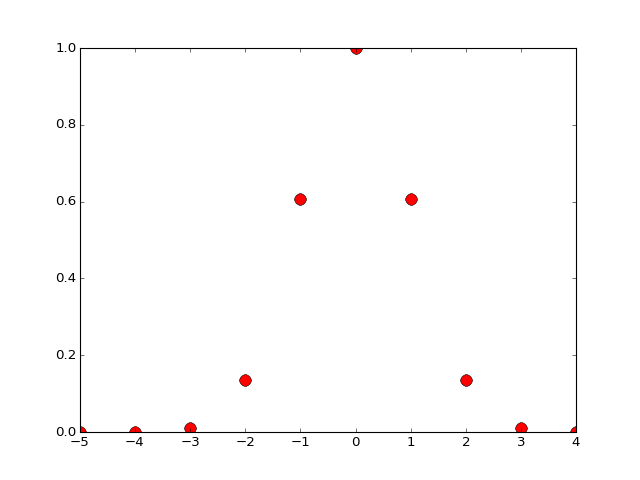

In [22]:
%matplotlib notebook
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

In [23]:
def stepscan(motor, detector):
    for i in range(-5, 5):
        yield Msg('create')
        yield Msg('set', motor, {'pos': i})
        yield Msg('trigger', motor)
        yield Msg('trigger', det)
        yield Msg('read', motor)
        yield Msg('read', detector)
        yield Msg('save')

def live_scalar_plotter(ax, y, x):
    x_data, y_data = [], []
    line, = ax.plot([], [], 'ro', markersize=10)
    def update_plot(doc):
        # Update with the latest data.
        x_data.append(doc['data'][x]['value'])
        y_data.append(doc['data'][y]['value'])
        line.set_data(x_data, y_data)
        # Rescale and redraw.
        ax.relim(visible_only=True)
        ax.autoscale_view(tight=True)
        ax.figure.canvas.draw()
    return update_plot

# Point the function to our axes above, and specify what to plot.
my_plotter = live_scalar_plotter(ax, 'intensity', 'pos')

RE.run(stepscan(motor, det), subscriptions={'event': my_plotter})

*** Emitted RunStart:
{'uid': '1bcd8b51-21ae-4c80-ad5b-8f1cd895ff8d', 'beamline_id': 'test', 'scan_id': 123, 'owner': 'tester', 'time': 1433039541.4556851}
MSG_CACHE None
create: (None), (), {}
   ret: None
MSG_CACHE None
set: (mover: motor), ({'pos': -5},), {}
   ret: None
MSG_CACHE None
trigger: (mover: motor), (), {}
   ret: None
MSG_CACHE None
trigger: (reader: sg), (), {}
   ret: None
MSG_CACHE None
read: (mover: motor), (), {}
   ret: {'pos': {'timestamp': 1433039541.5864153, 'value': -5}}
MSG_CACHE None
read: (reader: sg), (), {}
   ret: {'intensity': {'timestamp': 1433039541.596735, 'value': 3.7266531720786709e-06}}
MSG_CACHE None
*** Emitted Event Descriptor:
{'run_start': '1bcd8b51-21ae-4c80-ad5b-8f1cd895ff8d', 'uid': '1eb1f096-d2e6-4bd4-86ab-a3fa35a8137b', 'time': 1433039541.627659, 'data_keys': {'pos': {'source': 'motor', 'dtype': 'number'}, 'I': {'source': 'sg', 'dtype': 'number'}}}
*** Emitted Event:
{'descriptor': '1eb1f096-d2e6-4bd4-86ab-a3fa35a8137b', 'uid': '7bcd16b5-

### Saving Documents to metadatastore

Mission-critical consumers can be run on the scan thread, where they will block the scan until they return from processing the emitted Documents. This should not be used for computationally heavy tasks like visualization. Its only intended use is for saving data to metadatastore, but users can register any consumers they want, at risk of slowing down the scan.

```
RE._register_scan_callback('event', some_critical_func)
```

The convenience function `register_mds` registers metadatastore's four `insert_*` functions to consume their four respective Documents. These are registered on the scan thread, so data is guaranteed to be saved in metadatastore.

In [20]:
%run register_mds.py

register_mds(RE)

We can verify that this worked by loading this one-point scan from the DataBroker and displaying the data using DataMuxer.

In [25]:
RE.run(simple_scan_saving(motor, det))

*** Emitted RunStart:
{'uid': 'd50c62b5-1127-4174-b4b9-8c022b73fa5a', 'beamline_id': 'test', 'scan_id': 123, 'owner': 'tester', 'time': 1433039543.7722633}
MSG_CACHE None
create: (None), (), {}
   ret: None
MSG_CACHE None
set: (mover: motor), ({'pos': 5},), {}
   ret: None
MSG_CACHE None
trigger: (mover: motor), (), {}
   ret: None
MSG_CACHE None
read: (mover: motor), (), {}
   ret: {'pos': {'timestamp': 1433039543.9101195, 'value': 5}}
MSG_CACHE None
read: (reader: sg), (), {}
   ret: {'intensity': {'timestamp': 1433039543.27964, 'value': 0.00033546262790251185}}
MSG_CACHE None
*** Emitted Event Descriptor:
{'run_start': 'd50c62b5-1127-4174-b4b9-8c022b73fa5a', 'uid': 'b1f40a88-d736-4eab-a23e-95fc8f21ceac', 'time': 1433039543.9409378, 'data_keys': {'pos': {'source': 'motor', 'dtype': 'number'}, 'I': {'source': 'sg', 'dtype': 'number'}}}
*** Emitted Event:
{'descriptor': 'b1f40a88-d736-4eab-a23e-95fc8f21ceac', 'uid': '22e73259-60bf-4a20-8d27-1f18c4211075', 'seq_num': 1, 'time': 14330395

In [26]:
from dataportal import DataBroker as db

header = db[-1]
header

<Header scan_id=123 run_start_uid='d50c62b5-1127-4174-b4b9-8c022b73fa5a'>

In [27]:
from dataportal import DataMuxer as dm

dm.from_events(db.fetch_events(header)).to_sparse_dataframe()

,intensity,pos,time
0,0.000335,5,1.433040e+09


## Flyscan prototype

   Asserts that flyscans are managed by an object which has three methods:
    
     - describe : same as for everything else
     - kickoff : method which starts the flyscan.  This should be a fast-to-
         	    execute function that is assumed to just poke at some external
                 hardware.
     - collect : collects the data from flyscan.  This method yields partial
                 event documents.  The 'time' and 'data' fields should be
                 filled in, the rest will be filled in by the run engine.


In [21]:
flyer = FlyMagic('flyer', 'theta', 'sin')

In [22]:
def fly_scan(flyer):
    yield Msg('kickoff', flyer)
    yield Msg('collect', flyer)
    yield Msg('kickoff', flyer)
    yield Msg('collect', flyer)
    # Note that there is no 'create'/'save' here. That is managed by 'collect'.

RE.run(fly_gen(flyer), use_threading=False)

*** Emitted RunStart:
{'time': 1433074217.910113, 'uid': 'b3bb171d-2be6-4ca8-9552-11de7161ffa5', 'owner': 'tester', 'scan_id': 123, 'beamline_id': 'test'}
MSG_CACHE None
kickoff: (flyer: flyer), (), {}
   ret: None
MSG_CACHE None
Emitted Event Descriptor:
{'uid': '7e929477-0150-4d36-a125-d48886b8262a', 'data_keys': {'sin': {'dtype': 'number', 'source': 'flyer'}, 'theta': {'dtype': 'number', 'source': 'flyer'}}, 'time': 1433074217.960202, 'run_start': 'b3bb171d-2be6-4ca8-9552-11de7161ffa5'}
Emitted Event:
{'time': 1433074217.9497859, 'uid': 'c53082e1-fe69-4462-b68d-fca77c415342', 'descriptor': '7e929477-0150-4d36-a125-d48886b8262a', 'seq_num': 1, 'data': {'sin': {'value': 0.3090169943749474, 'timestamp': 1433074217.9497859}, 'theta': {'value': 0.0, 'timestamp': 1433074217.9497859}}}
Emitted Event:
{'time': 1433074217.9509051, 'uid': 'd865bf65-8341-4beb-8337-87401fbf3193', 'descriptor': '7e929477-0150-4d36-a125-d48886b8262a', 'seq_num': 2, 'data': {'sin': {'value': 0.6910626489868646, 't

The fly scan results are in metadatastore....

In [23]:
header = db[-1]
header

<Header scan_id=123 run_start_uid='b3bb171d-2be6-4ca8-9552-11de7161ffa5'>

In [24]:
res = dm.from_events(db.fetch_events(header)).to_sparse_dataframe()
res

,sin,theta,time
0,0.309017,0.000000,2015-05-31 12:10:17.949786
1,0.691063,0.448799,2015-05-31 12:10:17.950905
2,0.936235,0.897598,2015-05-31 12:10:17.952024
3,0.995974,1.346397,2015-05-31 12:10:17.953144
4,0.858449,1.795196,2015-05-31 12:10:17.954263
5,0.550897,2.243995,2015-05-31 12:10:17.955382
6,0.134233,2.692794,2015-05-31 12:10:17.956501
7,-0.309017,3.141593,2015-05-31 12:10:17.957620
8,-0.691063,3.590392,2015-05-31 12:10:17.958740
9,-0.936235,4.039191,2015-05-31 12:10:17.959859


In [25]:
fig, ax = plt.subplots()

NameError: name 'plt' is not defined

In [33]:
ax.cla()
res = dm.from_events(db.fetch_events(header)).to_sparse_dataframe()
ax.plot(res['sin'], label='sin')
ax.plot(res['theta'], label='theta')
ax.legend()
fig.canvas.draw()

### Fly scan + stepscan

Do a step scan with one motor and a fly scan with another

In [33]:
def fly_step(flyer, motor):
    for x in range(-5, 5):
        # step
        yield Msg('create')
        yield Msg('set', motor, {'pos': x})
        yield Msg('trigger', motor)
        yield Msg('read', motor)
        yield Msg('save')
        # fly
        yield Msg('kickoff', flyer)
        yield Msg('collect', flyer)

In [34]:
flyer.reset()
RE.run(fly_step(flyer, motor))

*** Emitted RunStart:
{'time': 1433074300.259759, 'uid': '86012b98-c6f5-4f2c-8f4d-3dfd427232ce', 'owner': 'tester', 'scan_id': 123, 'beamline_id': 'test'}
MSG_CACHE None
create: (None), (), {}
   ret: None
MSG_CACHE None
set: (mover: motor), ({'pos': -5},), {}
   ret: None
MSG_CACHE None
trigger: (mover: motor), (), {}
   ret: None
MSG_CACHE None
read: (mover: motor), (), {}
   ret: {'pos': {'value': -5, 'timestamp': 1433074300.3996}}
MSG_CACHE None
*** Emitted Event Descriptor:
{'uid': '885b1e6f-b8d9-45c8-99bf-5bae20b5897b', 'data_keys': {'pos': {'dtype': 'number', 'source': 'motor'}}, 'time': 1433074300.425076, 'run_start': '86012b98-c6f5-4f2c-8f4d-3dfd427232ce'}
*** Emitted Event:
{'uid': '4691a1a3-2727-4909-b4c1-bca8b31da558', 'time': 1433074300.429001, 'descriptor': '885b1e6f-b8d9-45c8-99bf-5bae20b5897b', 'seq_num': 1, 'data': {'pos': {'value': -5, 'timestamp': 1433074300.3996}}}
save: (None), (), {}
   ret: None
MSG_CACHE None
kickoff: (flyer: flyer), (), {}
   ret: None
MSG_CACH

In [35]:
header = db[-1]
header

<Header scan_id=123 run_start_uid='86012b98-c6f5-4f2c-8f4d-3dfd427232ce'>

In [36]:
mux = dm.from_events(db.fetch_events(header))

In [37]:
res = mux.bin_on('sin', interpolation={'pos':'nearest'})

<IPython.core.display.Javascript object>


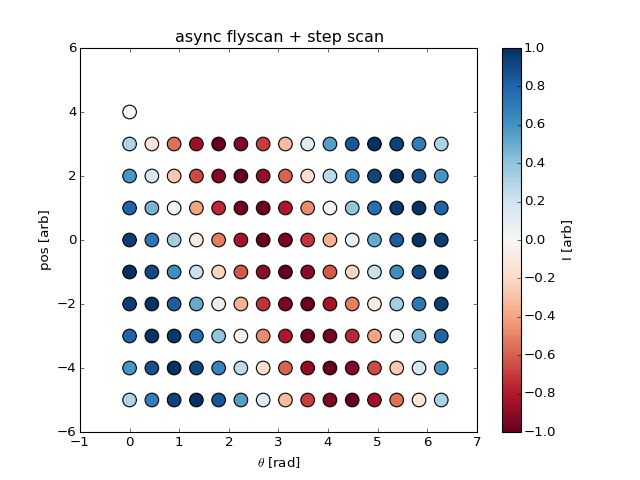

In [38]:
%matplotlib notebook
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

In [39]:
sc = ax.scatter(res.theta.val.values, res.pos.val.values, c=res.sin.values, s=150, cmap='RdBu')
cb = fig.colorbar(sc)
cb.set_label('I [arb]')
ax.set_xlabel(r'$\theta$ [rad]')
ax.set_ylabel('pos [arb]')
ax.set_title('async flyscan + step scan')
fig.canvas.draw()

In [40]:
res

pos                 sin     theta                       time        \
    val count           val       val                        val count   
bin                                                                      
0    -5     1  3.090170e-01  0.000000 2015-05-31 12:11:40.436950     2   
1    -5     0  6.910626e-01  0.448799 2015-05-31 12:11:40.445948     1   
2    -5     0  9.362349e-01  0.897598 2015-05-31 12:11:40.446996     1   
3    -5     0  9.959743e-01  1.346397 2015-05-31 12:11:40.448045     1   
4    -5     0  8.584488e-01  1.795196 2015-05-31 12:11:40.449094     1   
5    -5     0  5.508970e-01  2.243995 2015-05-31 12:11:40.450143     1   
6    -5     0  1.342333e-01  2.692794 2015-05-31 12:11:40.451191     1   
7    -5     0 -3.090170e-01  3.141593 2015-05-31 12:11:40.452240     1   
8    -5     0 -6.910626e-01  3.590392 2015-05-31 12:11:40.453289     1   
9    -5     0 -9.362349e-01  4.039191 2015-05-31 12:11:40.454338     1   
10   -5     0 -9.959743e-01  4.487990 2015-05-31 12:11:40.455386     1   
11   -5     0 -8.584488e-01  4.936788 2015-05-31 12:11:40.456435     1   
12   -5     0 -5.508970e-01  5.385587 2015-05-31 12:11:40.457484     1   
13   -5     0 -1.342333e-01  5.834386 2015-05-31 12:11:40.458533     1   
14   -5     0  3.090170e-01  6.283185 2015-05-31 12:11:40.459581     1   
15   -4     1  5.877853e-01  0.000000 2015-05-31 12:11:40.667560     2   
16   -4     0  8.805955e-01  0.448799 2015-05-31 12:11:40.676091     1   
17   -4     0  9.989931e-01  0.897598 2015-05-31 12:11:40.676932     1   
18   -4     0  9.195278e-01  1.346397 2015-05-31 12:11:40.677773     1   
19   -4     0  6.579387e-01  1.795196 2015-05-31 12:11:40.678613     1   
20   -4     0  2.660368e-01  2.243995 2015-05-31 12:11:40.679454     1   
21   -4     0 -1.785569e-01  2.692794 2015-05-31 12:11:40.680294     1   
22   -4     0 -5.877853e-01  3.141593 2015-05-31 12:11:40.681135     1   
23   -4     0 -8.805955e-01  3.590392 2015-05-31 12:11:40.681975     1   
24   -4     0 -9.989931e-01  4.039191 2015-05-31 12:11:40.682816     1   
25   -4     0 -9.195278e-01  4.487990 2015-05-31 12:11:40.683656     1   
26   -4     0 -6.579387e-01  4.936788 2015-05-31 12:11:40.684497     1   
27   -4     0 -2.660368e-01  5.385587 2015-05-31 12:11:40.685338     1   
28   -4     0  1.785569e-01  5.834386 2015-05-31 12:11:40.686178     1   
29   -4     0  5.877853e-01  6.283185 2015-05-31 12:11:40.687019     1   
..   ..   ...           ...       ...                        ...   ...   
120   3     1  3.090170e-01  0.000000 2015-05-31 12:11:42.291442     2   
121   3     0 -1.342333e-01  0.448799 2015-05-31 12:11:42.300675     1   
122   3     0 -5.508970e-01  0.897598 2015-05-31 12:11:42.301412     1   
123   3     0 -8.584488e-01  1.346397 2015-05-31 12:11:42.302150     1   
124   3     0 -9.959743e-01  1.795196 2015-05-31 12:11:42.302887     1   
125   3     0 -9.362349e-01  2.243995 2015-05-31 12:11:42.303624     1   
126   3     0 -6.910626e-01  2.692794 2015-05-31 12:11:42.304361     1   
127   3     0 -3.090170e-01  3.141593 2015-05-31 12:11:42.305098     1   
128   3     0  1.342333e-01  3.590392 2015-05-31 12:11:42.305836     1   
129   3     0  5.508970e-01  4.039191 2015-05-31 12:11:42.306573     1   
130   3     0  8.584488e-01  4.487990 2015-05-31 12:11:42.307310     1   
131   3     0  9.959743e-01  4.936788 2015-05-31 12:11:42.308047     1   
132   3     0  9.362349e-01  5.385587 2015-05-31 12:11:42.308784     1   
133   3     0  6.910626e-01  5.834386 2015-05-31 12:11:42.309522     1   
134   3     0  3.090170e-01  6.283185 2015-05-31 12:11:42.310259     1   
135   4     1  1.224647e-16  0.000000 2015-05-31 12:11:42.526517     2   
136 NaN     0 -4.338837e-01  0.448799 2015-05-31 12:11:42.535753     1   
137 NaN     0 -7.818315e-01  0.897598 2015-05-31 12:11:42.536609     1   
138 NaN     0 -9.749279e-01  1.346397 2015-05-31 12:11:42.537464     1   
139 NaN     0 -9.749279e-01  1.795196 2015-05-31 12:11:42.538319     1   
140 NaN 